In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalNormalSimulator, MainSimulator
from src.python.losses import softmax_loss
from src.python.helpers import n_clust_obs_f_f, get_repeated_predictions, get_bootstrapped_predictions, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_calibration_curve_repetition_uncertainty

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up networks

In [3]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
probability_net = ModelProbabilityNetwork(probability_meta_validation)

amortizer = MultiModelAmortizer(probability_net, summary_net)

simulator = MainSimulator(HierarchicalNormalSimulator())

In [4]:
# Training steps
epochs=10 
iterations_per_epoch=1000

# Cosine decaying learning rate
initial_lr = 0.0005
decay_steps = epochs*iterations_per_epoch
alpha = 0
lr_schedule = CosineDecay(
    initial_lr, decay_steps, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = 'C:\\Users\\lasse\\Documents\\hierarchical_model_comparison_project\\checkpoints\\01_calibration_validation\\checkpoints_fixed'

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(softmax_loss),
    optimizer=partial(Adam, lr_schedule),
    checkpoint_path=checkpoint_path,
    skip_checks=True,
    )

Networks loaded from C:\Users\lasse\Documents\hierarchical_model_comparison_project\checkpoints\01_calibration_validation\checkpoints_fixed\ckpt-10


# Train & validate

In [5]:
training_time_start = perf_counter()
losses = trainer.train_online(epochs=epochs, iterations_per_epoch=iterations_per_epoch, batch_size=32, n_obs=n_clust_obs_f_f)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

ECE = 0.038


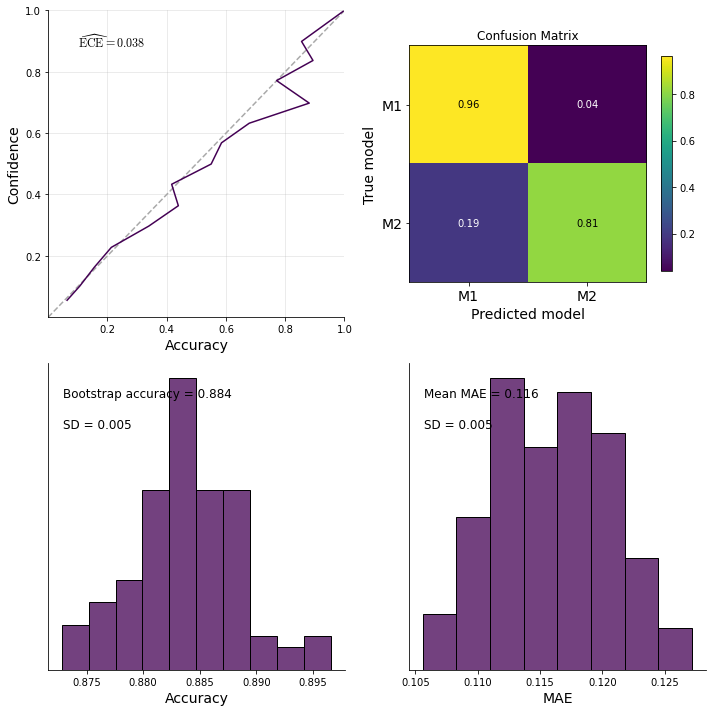

In [5]:
# Validation
n_val = 5000
m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
val_data = {'X' : x_val, 'm' : m_val}

perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

[0.02838795 0.02768253 0.03474504 0.02783486 0.0268203  0.03975554
 0.04531947 0.03313179 0.027888   0.02907091 0.02768803 0.03613889
 0.02157843 0.04519844 0.03971981 0.03632822 0.04297879 0.03646908
 0.01895627 0.03458403 0.03160711 0.03439038 0.03776452 0.04288215
 0.02546689]
Median ECE = 0.034390382042253


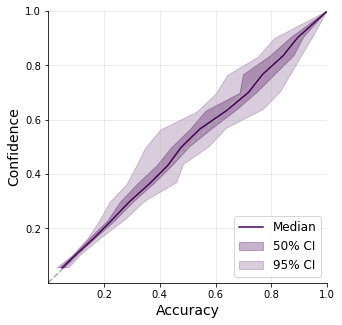

In [8]:
# Plot calibration with repetition uncertainty
n_repetitions = 25

fig, ax = plt.subplots(1, 1, figsize=(5,5))
m_true_r, m_soft_r = get_repeated_predictions(probability_net, summary_net, partial(simulator, batch_size=n_val, n_obs=n_clust_obs_f_f(50, 50)), 
                                          n_models=2, n_repetitions=n_repetitions)

plot_calibration_curve_repetition_uncertainty(m_true_r[:,:,1], m_soft_r[:,:,1], narrow_ci=[0.25, 0.75], wide_ci=[0.025, 0.975], n_bins=15, ax=ax, 
                                    xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

fig.savefig('calibration_fixed.pdf', dpi=300, bbox_inches='tight')

ECE = 0.040


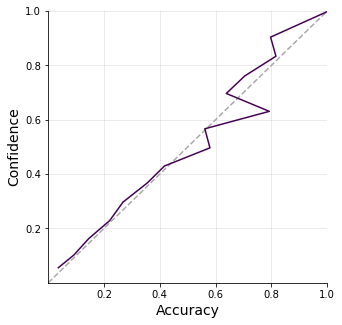

In [6]:
# Plot single cal curve
from src.python.visualization import plot_calibration_curve
fig, ax = plt.subplots(figsize=(5,5))

m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
val_data = {'X' : x_val, 'm' : m_val}

# Compute model predictions in chunks so GPU memory does not blow-up
m_soft = tf.concat([probability_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(val_data['X'], 20)], axis=0).numpy()
m_hard = (m_soft > 0.5).astype(np.int32)
m_true = val_data['m'][:, 1]
plot_calibration_curve(m_true, m_soft, n_bins=15, ax=ax, show_ece=False)

In [13]:
# Manual ECE computation so far: unweighted
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(m_true, m_soft, n_bins=15)
cal_err = np.mean(np.abs(prob_true - prob_pred))
cal_err

0.0399615460351028

In [31]:
# compute ECE manually
# proposed sklearn implementation
# https://github.com/scikit-learn/scikit-learn/blob/643330dda5c90c44650a2eea6f66814e5182a3e1/sklearn/metrics/_classification.py

from sklearn.utils import column_or_1d, assert_all_finite, check_consistent_length

def sklearn_calibration_error(y_true, y_prob, sample_weight=None, norm='l2',
                      n_bins=10, strategy='uniform', pos_label=None,
                      reduce_bias=True):
    """Compute calibration error of a binary classifier.
    Across all items in a set of N predictions, the calibration error measures
    the aggregated difference between (1) the average predicted probabilities
    assigned to the positive class, and (2) the frequencies
    of the positive class in the actual outcome.
    The calibration error is only appropriate for binary categorical outcomes.
    Which label is considered to be the positive label is controlled via the
    parameter pos_label, which defaults to 1.
    Read more in the :ref:`User Guide <calibration>`.
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True targets of a binary classification task.
    y_prob : array-like of (n_samples,)
        Probabilities of the positive class.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    norm : {'l1', 'l2', 'max'}, default='l2'
        Norm method. The l1-norm is the Expected Calibration Error (ECE),
        and the max-norm corresponds to Maximum Calibration Error (MCE).
    n_bins : int, default=10
       The number of bins to compute error on.
    strategy : {'uniform', 'quantile'}, default='uniform'
        Strategy used to define the widths of the bins.
        uniform
            All bins have identical widths.
        quantile
            All bins have the same number of points.
    pos_label : int or str, default=None
        Label of the positive class. If None, the maximum label is used as
        positive class.
    reduce_bias : bool, default=True
        Add debiasing term as in Verified Uncertainty Calibration, A. Kumar.
        Only effective for the l2-norm.
    Returns
    -------
    score : float
        calibration error
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.metrics import calibration_error
    >>> y_true = np.array([0, 0, 0, 1] + [0, 1, 1, 1])
    >>> y_pred = np.array([0.25, 0.25, 0.25, 0.25] + [0.75, 0.75, 0.75, 0.75])
    >>> calibration_error(y_true, y_pred, n_bins=5)
    0.0
    >>> calibration_error(
    ...     y_true, y_pred, n_bins=5, norm="max"
    ... )
    0.0
    >>> y_true = np.array([0, 0, 0, 0] + [1, 1, 1, 1])
    >>> calibration_error(y_true, y_pred, n_bins=5)
    0.25
    >>> calibration_error(
    ...     y_true, y_pred, n_bins=5, norm="max"
    ... )
    0.25
    """
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)
    assert_all_finite(y_true)
    assert_all_finite(y_prob)
    check_consistent_length(y_true, y_prob, sample_weight)
    if any(y_prob < 0) or any(y_prob > 1):
        raise ValueError("y_prob has values outside of [0, 1] range")

    labels = np.unique(y_true)
    if len(labels) > 2:
        raise ValueError("Only binary classification is supported. "
                         "Provided labels %s." % labels)

    if pos_label is None:
        pos_label = y_true.max()
    if pos_label not in labels:
        raise ValueError("pos_label=%r is not a valid label: "
                         "%r" % (pos_label, labels))
    y_true = np.array(y_true == pos_label, int)

    norm_options = ('l1', 'l2', 'max')
    if norm not in norm_options:
        raise ValueError(f'norm has to be one of {norm_options}, got: {norm}.')

    remapping = np.argsort(y_prob)
    y_true = y_true[remapping]
    y_prob = y_prob[remapping]
    if sample_weight is not None:
        sample_weight = sample_weight[remapping]
    else:
        sample_weight = np.ones(y_true.shape[0])

    n_bins = int(n_bins)
    if strategy == 'quantile':
        quantiles = np.percentile(y_prob, np.arange(0, 1, 1.0 / n_bins) * 100)
    elif strategy == 'uniform':
        quantiles = np.arange(0, 1, 1.0 / n_bins)
    else:
        raise ValueError(
            f"Invalid entry to 'strategy' input. Strategy must be either "
            f"'quantile' or 'uniform'. Got {strategy} instead."
        )

    threshold_indices = np.searchsorted(y_prob, quantiles).tolist()
    threshold_indices.append(y_true.shape[0])
    avg_pred_true = np.zeros(n_bins)
    bin_centroid = np.zeros(n_bins)
    delta_count = np.zeros(n_bins)
    debias = np.zeros(n_bins)

    loss = 0.
    count = float(sample_weight.sum())
    for i, i_start in enumerate(threshold_indices[:-1]):
        i_end = threshold_indices[i + 1]
        # ignore empty bins
        if i_end == i_start:
            continue
        delta_count[i] = float(sample_weight[i_start:i_end].sum())
        avg_pred_true[i] = (np.dot(y_true[i_start:i_end],
                                   sample_weight[i_start:i_end])
                            / delta_count[i])
        bin_centroid[i] = (np.dot(y_prob[i_start:i_end],
                                  sample_weight[i_start:i_end])
                           / delta_count[i])
        if norm == "l2" and reduce_bias:
            delta_debias = (
                avg_pred_true[i] * (avg_pred_true[i] - 1) * delta_count[i]
            )
            delta_debias /= (count * delta_count[i] - 1)
            debias[i] = delta_debias

    if norm == "max":
        loss = np.max(np.abs(avg_pred_true - bin_centroid))
    elif norm == "l1":
        delta_loss = np.abs(avg_pred_true - bin_centroid) * delta_count
        loss = np.sum(delta_loss) / count
    elif norm == "l2":
        delta_loss = (avg_pred_true - bin_centroid)**2 * delta_count
        loss = np.sum(delta_loss) / count
        if reduce_bias:
            loss += np.sum(debias)
        loss = np.sqrt(max(loss, 0.))
    return loss

sklearn_calibration_error(y_true=m_true, y_prob=m_soft, norm='l1', n_bins=15)

0.014225145535171006

In [87]:
# compute ECE manually
# supplement sklearn calibration curve with ece computation
# sklearn cal curve: https://github.com/scikit-learn/scikit-learn/blob/dc580a8ef/sklearn/calibration.py#L910
# suggestion for ece supplementation: https://github.com/scikit-learn/scikit-learn/issues/18268

from sklearn.utils import column_or_1d, assert_all_finite, check_consistent_length
from sklearn.metrics._base import _check_pos_label_consistency

def calibration_curve_with_ece(
    y_true,
    y_prob,
    pos_label=None,
    n_bins=15,
    strategy="uniform",
):
    """
    [sklearn.calibration.calibration_curve source code supplemented with an ECE calculation 
     proposed by chrisyeh96 in issue #18268 of the scikit-learn github repository.]
    Compute true and predicted probabilities for a calibration curve.
    The method assumes the inputs come from a binary classifier, and
    discretize the [0, 1] interval into bins.
    Calibration curves may also be referred to as reliability diagrams.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True targets.
    y_prob : array-like of shape (n_samples,)
        Probabilities of the positive class.
    pos_label : int or str, default=None
        The label of the positive class.
        .. versionadded:: 1.1
    n_bins : int, default=5
        Number of bins to discretize the [0, 1] interval. A bigger number
        requires more data. Bins with no samples (i.e. without
        corresponding values in `y_prob`) will not be returned, thus the
        returned arrays may have less than `n_bins` values.
    strategy : {'uniform', 'quantile'}, default='uniform'
        Strategy used to define the widths of the bins.
        uniform
            The bins have identical widths.
        quantile
            The bins have the same number of samples and depend on `y_prob`.
    Returns
    -------
    prob_true : ndarray of shape (n_bins,) or smaller
        The proportion of samples whose class is the positive class, in each
        bin (fraction of positives).
    prob_pred : ndarray of shape (n_bins,) or smaller
        The mean predicted probability in each bin.
    References
    ----------
    Alexandru Niculescu-Mizil and Rich Caruana (2005) Predicting Good
    Probabilities With Supervised Learning, in Proceedings of the 22nd
    International Conference on Machine Learning (ICML).
    See section 4 (Qualitative Analysis of Predictions).
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.calibration import calibration_curve
    >>> y_true = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])
    >>> y_pred = np.array([0.1, 0.2, 0.3, 0.4, 0.65, 0.7, 0.8, 0.9,  1.])
    >>> prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=3)
    >>> prob_true
    array([0. , 0.5, 1. ])
    >>> prob_pred
    array([0.2  , 0.525, 0.85 ])
    """
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)
    check_consistent_length(y_true, y_prob)
    pos_label = _check_pos_label_consistency(pos_label, y_true)

    if y_prob.min() < 0 or y_prob.max() > 1:
        raise ValueError("y_prob has values outside [0, 1].")

    labels = np.unique(y_true)
    if len(labels) > 2:
        raise ValueError(
            f"Only binary classification is supported. Provided labels {labels}."
        )
    y_true = y_true == pos_label

    if strategy == "quantile":  # Determine bin edges by distribution of data
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.percentile(y_prob, quantiles * 100)
    elif strategy == "uniform":
        bins = np.linspace(0.0, 1.0, n_bins + 1)
    else:
        raise ValueError(
            "Invalid entry to 'strategy' input. Strategy "
            "must be either 'quantile' or 'uniform'."
        )

    binids = np.searchsorted(bins[1:-1], y_prob)

    accurate_pred = y_true == (y_prob > 0.5)
    bin_matches = np.bincount(binids, weights=accurate_pred, minlength=len(bins))
    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))
    
    

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]
    bin_accuracy = bin_matches[nonzero] / bin_total[nonzero]

    print(bin_matches[nonzero])
    print(bin_total[nonzero])
    print(bin_accuracy)
    print(prob_pred)
    # Method proposed by chrisyeh96
    # https://github.com/scikit-learn/scikit-learn/issues/18268
    ece = np.sum(np.abs(prob_true - prob_pred) * (bin_total[nonzero] / len(y_true)))

    # Correction proposed by EvanLavizadeh
    # ECE uses accuracy in each bin and not proportion of positive class
    # https://github.com/scikit-learn/scikit-learn/issues/18268
    ece_with_accuracy = np.sum(np.abs(bin_accuracy - prob_pred) * (bin_total[nonzero] / len(y_true)))

    # Our method thus far (unweighted average of bin errors)
    our_unweighted_ece = np.mean(np.abs(prob_true - prob_pred))

    return prob_true, prob_pred, ece, ece_with_accuracy, our_unweighted_ece

calibration_curve_with_ece(y_true=m_true, y_prob=m_soft, n_bins=15)[2:]

[ 266.  890.  757.  245.  120.   80.   56.   38.   32.   42.   30.   31.
   40.   55. 1769.]
[ 276  980  886  314  164  124   96   69   57   53   47   44   49   69
 1772]
[0.96376812 0.90816327 0.85440181 0.78025478 0.73170732 0.64516129
 0.58333333 0.55072464 0.56140351 0.79245283 0.63829787 0.70454545
 0.81632653 0.79710145 0.998307  ]
[0.05548743 0.10203113 0.16297294 0.22819437 0.29699019 0.3671374
 0.42967404 0.49647105 0.56663329 0.63082048 0.6966176  0.76102143
 0.83358508 0.90382198 0.99703723]


(0.014225145535171008, 0.3950922518089414, 0.0399615460351028)

In [8]:
# Calculate calibration bins manually for each sample

# bins for sampled cal curves
from sklearn.calibration import calibration_curve
n_bins=15

# Get bins & ECE for each sample from the learned dirichlet distribution
probs_true = np.zeros((n_samples, n_bins))
probs_pred = np.zeros((n_samples, n_bins))

for n in range(n_samples):
    m_soft = pm_samples_model[:, n]
    probs_true[n, :], probs_pred[n, :] = calibration_curve(m_true, m_soft, n_bins=n_bins)
cal_err = np.mean(np.abs(probs_true - probs_pred))

(array([   6.,   67.,  392., 1350., 2599., 2987., 1799.,  651.,  135.,
          14.]),
 array([0.09029839, 0.09590304, 0.10150769, 0.10711234, 0.11271698,
        0.11832163, 0.12392628, 0.12953093, 0.13513557, 0.14074022,
        0.14634487]),
 <BarContainer object of 10 artists>)

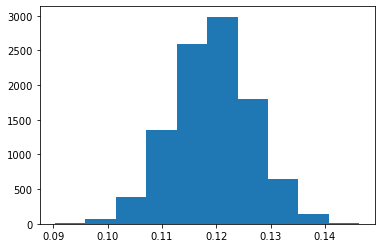

In [9]:
# ECE distribution over samples
plt.hist(np.mean(np.abs(probs_true - probs_pred), axis=1))

## Plot PMPs (dirichlet mean) against sampled PMPs

In [10]:
# Get PMPs (mean of dirichlet)
alphas0 = np.sum(alphas, axis=1, keepdims=True)
means = alphas / alphas0

# Filter for probabilities for m2
means_m2 = means[:,1]
pm_samples_m2 = pm_samples[:,:,1]

# Get standard deviations of the dirichlet
vars = alphas * (alphas0 - alphas) / (alphas0 * alphas0 * (alphas0 + 1))
stds = np.sqrt(vars)

In [11]:
# Sort by PMPs
means_m2_indices = means_m2.argsort()
sorted_means_m2 = means_m2[means_m2_indices]
sorted_samples_m2 = pm_samples_m2[means_m2_indices, :]

# Get quantiles of samples
lower_bound, upper_bound = np.quantile(sorted_samples_m2, q=[0.025, 0.975], axis=1)

# Get median
sample_median = np.squeeze(np.quantile(sorted_samples_m2, q=[0.5], axis=1))

# Get mean
sample_mean = np.mean(sorted_samples_m2, axis=1)

### Plot PMPs sorted separately

In [12]:
# Analytical mean +/- 1 std
means_plus_stds = means_m2 + stds[:, 1]
means_minus_stds = means_m2 - stds[:, 1]

# Sorted by analytical mean
means_plus_stds_sorted = (means_m2 + stds[:, 1])[means_m2_indices]
means_minus_stds_sorted = (means_m2 - stds[:, 1])[means_m2_indices]

Text(0.5, 1.0, 'Samples sorted separately')

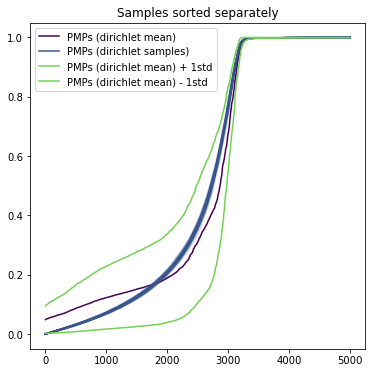

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x_axis = np.linspace(1,means_m2.shape[0], num=means_m2.shape[0])

# Plot dirichlet mean
ax.plot(x_axis, np.sort(means_m2), color='#440154FF', label='PMPs (dirichlet mean)')

# Plot single samples
# for i in range(pm_samples_m2.shape[1]):
for i in range(100):
    ax.plot(x_axis, np.sort(pm_samples_m2[:,i]), color='#39568CFF', alpha=0.1)
ax.plot([], [], color='#39568CFF', label='PMPs (dirichlet samples)') # only add one line to legend

# Plot dirichlet mean +/- stds
ax.plot(x_axis, np.sort(means_plus_stds), color='#73D055FF', label='PMPs (dirichlet mean) + 1std')
ax.plot(x_axis, np.sort(means_minus_stds), color='#73D055FF', label='PMPs (dirichlet mean) - 1std')

ax.legend()
ax.set_title('Samples sorted separately')

In [17]:
np.mean(pm_samples_m2, axis=1).shape

(5000,)

Text(0.5, 1.0, 'Samples sorted separately')

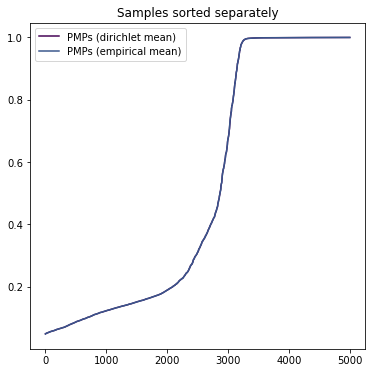

In [18]:
# Alphas instead of PMPs
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x_axis = np.linspace(1,means_m2.shape[0], num=means_m2.shape[0])

# Plot analytical mean
ax.plot(x_axis, np.sort(means_m2), color='#440154FF', label='PMPs (dirichlet mean)')

# Plot empirical mean
ax.plot(x_axis, np.sort(np.mean(pm_samples_m2, axis=1)), color='#39568CFF', label='PMPs (empirical mean)')

ax.legend()
ax.set_title('Samples sorted separately')

### Plot PMPs sorted by PMPs (dirichlet mean)

Text(0.5, 1.0, 'Samples sorted by analytical mean')

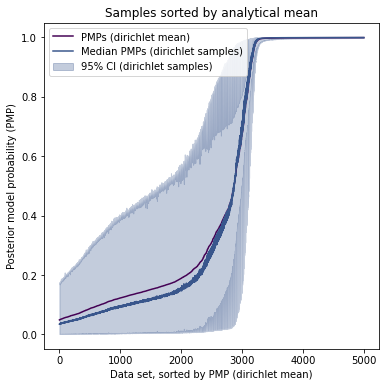

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x_axis = np.linspace(1,means_m2.shape[0], num=means_m2.shape[0])
# ax.plot(x_axis, means_plus_stds_sorted, color='#73D055FF', label='PMPs (dirichlet mean) + 1std')
# ax.plot(x_axis, means_minus_stds_sorted, color='#73D055FF', label='PMPs (dirichlet mean) - 1std')
ax.plot(x_axis, sorted_means_m2, color='#440154FF', label='PMPs (dirichlet mean)')
ax.plot(x_axis, sample_median, color='#39568CFF', label='Median PMPs (dirichlet samples)')
# ax.plot(x_axis, sample_mean, color='#1F968BFF', label='Mean PMPs (dirichlet samples)')
ax.fill_between(x_axis, lower_bound, upper_bound, color='#39568CFF', alpha=0.3, label='95% CI (dirichlet samples)')
ax.set_xlabel('Data set, sorted by PMP (dirichlet mean)')
ax.set_ylabel('Posterior model probability (PMP)')
ax.legend()
ax.set_title('Samples sorted by analytical mean')

### Plot calibration curves with analytical stds

In [93]:
predictions = probability_net.predict(summary_net(val_data['X']))
probs = predictions['m_probs']

In [94]:
# +/- vars
probs_plus_var = predictions['m_probs'] + predictions['m_var']
probs_minus_var = predictions['m_probs'] - predictions['m_var']

# +/- stds
probs_plus_stds = predictions['m_probs'] + np.sqrt(predictions['m_var'])
probs_minus_stds = predictions['m_probs'] - np.sqrt(predictions['m_var'])

In [114]:
# Plot calibration curve
m_true = val_data['m'][:, 1]
prob_true, prob_pred = calibration_curve(m_true, probs[:, 1], n_bins=15)
prob_true_plus_var, prob_pred_plus_var = calibration_curve(m_true, probs_plus_var[:, 1], n_bins=15)
prob_true_minus_var, prob_pred_minus_var = calibration_curve(m_true, probs_minus_var[:, 1], n_bins=15)
prob_true_plus_stds, prob_pred_plus_stds = calibration_curve(m_true, probs_plus_stds[:, 1], n_bins=15)
prob_true_minus_stds, prob_pred_minus_stds = calibration_curve(m_true, probs_minus_stds[:, 1], n_bins=15)

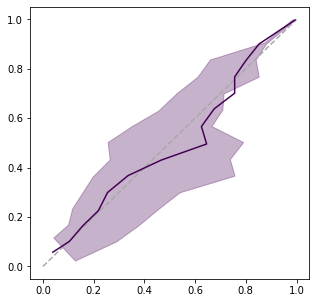

In [115]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot((0,1), (0,1), '--', color='darkgrey')
ax.plot(prob_true, prob_pred, color='#440154FF', label='PMPs (dirichlet mean)')
# ax.fill(np.append(prob_true_plus_var, prob_true_minus_var[::-1]),
#         np.append(prob_pred_plus_var, prob_pred_minus_var[::-1]),
#         color='#440154FF', alpha=0.3, label='+/- 1var')
ax.fill(np.append(prob_true_plus_stds, prob_true_minus_stds[::-1]),
        np.append(prob_pred_plus_stds, prob_pred_minus_stds[::-1]),
        color='#440154FF', alpha=0.3, label='+/- 1var')

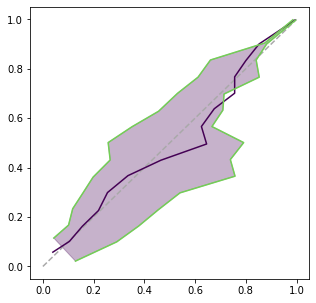

In [116]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot((0,1), (0,1), '--', color='darkgrey')
ax.plot(prob_true, prob_pred, color='#440154FF', label='PMPs (dirichlet mean)')
# ax.fill(np.append(prob_true_plus_var, prob_true_minus_var[::-1]),
#         np.append(prob_pred_plus_var, prob_pred_minus_var[::-1]),
#         color='#440154FF', alpha=0.3, label='+/- 1var')
ax.fill(np.append(prob_true_minus_stds, prob_true_plus_stds[::-1]),
        np.append(prob_pred_minus_stds, prob_pred_plus_stds[::-1]),
        color='#440154FF', alpha=0.3, label='+/- 1var')
ax.plot(prob_true_minus_stds, prob_pred_minus_stds, color='#73D055FF', label='PMPs (dirichlet mean)')
ax.plot(prob_true_plus_stds, prob_pred_plus_stds, color='#73D055FF', label='PMPs (dirichlet mean)')

In [14]:
# Save training meta-information for bridge sampling comparison?
save_training_vars = False

if save_training_vars:
    folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '01_calibration_validation', '01_fixed')

    np.save(os.path.join(folder, 'training_time_start'), training_time_start, allow_pickle=True)
    np.save(os.path.join(folder, 'training_time_stop'), training_time_stop, allow_pickle=True)
    np.save(os.path.join(folder, 'losses'), losses, allow_pickle=True)

# Calculate Bayes factors for bridge sampling comparison

In [2]:
# Import training meta-information? (if network was loaded from checkpoint)
import_training_vars = True

if import_training_vars:
    folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '01_calibration_validation', '01_fixed')

    training_time_start = np.load(os.path.join(folder, 'training_time_start.npy'), allow_pickle=True)
    training_time_stop = np.load(os.path.join(folder, 'training_time_stop.npy'), allow_pickle=True)
    losses = np.load(os.path.join(folder, 'losses.npy'), allow_pickle=True).item()

In [9]:
# Import test data
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '02_bridge_sampling_comparison', 'nested_models')
data_filename = "test_data.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [10]:
# Get NN predictions
comparison_results = get_preds_and_bfs(probability_net, summary_net, test_data, training_time_start, training_time_stop, losses)
comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.830225,0.169775,0,0.204492,745.100906,0.002514,0.287687
1,2,0,0.880637,0.119363,0,0.135542,745.100906,0.002514,0.287687
2,3,0,0.882400,0.117600,0,0.133273,745.100906,0.002514,0.287687
3,4,1,0.000001,0.999999,1,838859.800000,745.100906,0.002514,0.287687
4,5,0,0.883319,0.116681,0,0.132094,745.100906,0.002514,0.287687


In [12]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_BF_NN_fixed')
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '02_bridge_sampling_comparison', 'nested_models')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)